Il s’agira cette fois de réaliser les implémentations de manière parallélisé.
Pour rappel, le multi-threading n’existe pas vraiment en Python à cause du GIL (possibilité de suppression dans les prochaines versions).

In [1]:
import threading
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import queue
from concurrent.futures import ThreadPoolExecutor
import multiprocessing as mp
import asyncio
import networkx as nx

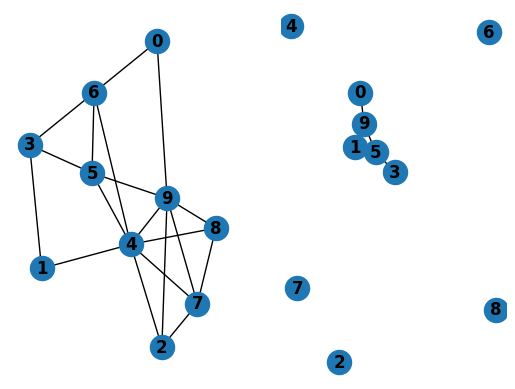

In [3]:
G1 = nx.gnp_random_graph(10, 0.5, directed=False)
G2 = nx.gnp_random_graph(10, 0.15, directed=False)

plt.subplot(121)
nx.draw(G1, with_labels=True, font_weight='bold')
plt.subplot(122)
nx.draw(G2, with_labels=True, font_weight='bold')
plt.show()

In [4]:
""" Implement the same function as this:
def est_clique(G, S):
    for v in S:
        for w in S:
            if v != w and not G.has_edge(v, w):
                return False
    return True

def recherche_clique(G):
    n = G.number_of_nodes()
    taille_max_clique = 0
    clique_max = set()
    for i in range(2**n):
        S = set()
        for j in range(n):
            if (i >> j) & 1:
                S.add(j)
        if len(S) > taille_max_clique and est_clique(G, S):
            taille_max_clique = len(S)
            clique_max = S
    return clique_max

But using a parallel algorithm.
"""

def est_clique(G, S):
    for v in S:
        for w in S:
            if v != w and not G.has_edge(v, w):
                return False
    return True

def recherche_clique_prl(G, i, n, result, lock):
    taille_max_clique = 0
    clique_max = set()
    S = set()
    for j in range(n):
        if (i >> j) & 1:
            S.add(j)
    if len(S) > taille_max_clique and est_clique(G, S):
        with lock:
            result.append((len(S), S))

def r_prl(G):
    n = G.number_of_nodes()
    result = []
    lock = threading.Lock()

    threads = []
    for i in range(2**n):
        thread = threading.Thread(target=recherche_clique_prl, args=(G, i, n, result, lock))
        thread.start()
        threads.append(thread)

    for thread in threads:
        thread.join()

    taille_max_clique, clique_max = max(result)
    print("Maximum Clique:", clique_max)

r_prl(G1)

Maximum Clique: {9, 2, 4, 7}


In [7]:
# Benchmark
def recherche_clique(G):
    n = G.number_of_nodes()
    taille_max_clique = 0
    clique_max = set()
    for i in range(2**n):
        S = set()
        for j in range(n):
            if (i >> j) & 1:
                S.add(j)
        if len(S) > taille_max_clique and est_clique(G, S):
            taille_max_clique = len(S)
            clique_max = S
    return clique_max

# benchmark between recherche_clique and r_prl
G = nx.gnp_random_graph(20, 0.5, directed=False)
print("Benchmarking...")
start = time.time()
recherche_clique(G)
end = time.time()
print("recherche_clique:", end - start)

start = time.time()
r_prl(G)
end = time.time()
print("r_prl:", end - start)


Benchmarking...
recherche_clique: 2.7766897678375244


KeyboardInterrupt: 

In [2]:
!pip install pyspark

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 8.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 11.6 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425364 sha256=08ea92b1a2d2dbe8b45d557ce373e92fa7b7f00ab2a4c56f3a4f3731c132456c
  Stored in directory: /home/coartix/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [3]:
from pyspark import SparkContext

sc = SparkContext("local", "CliqueSearchApp")  # Initialize SparkContext

# Assuming G is a NetworkX graph
edges = G.edges().flatMap(lambda e: [(e[0], e[1]), (e[1], e[0])])  # Convert edges to bidirectional edges
graph_rdd = sc.parallelize(edges.groupByKey().mapValues(set).collect())

23/11/15 14:23:07 WARN Utils: Your hostname, coartix-ubuntu resolves to a loopback address: 127.0.1.1; using 10.41.178.221 instead (on interface wlp0s20f3)
23/11/15 14:23:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/15 14:23:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


NameError: name 'G' is not defined

In [ ]:
def est_clique_dist(RDD, S):
    return RDD.filter(lambda x: x[0] in S).flatMap(lambda x: x[1]).distinct().count() == len(S)

def recherche_clique_dist(RDD):
    n = RDD.count()
    taille_max_clique = 0
    clique_max = set()
    for i in range(2**n):
        S = set()
        for j in range(n):
            if (i >> j) & 1:
                S.add(j)
        if len(S) > taille_max_clique and est_clique_dist(RDD, S):
            taille_max_clique = len(S)
            clique_max = S
    return clique_max

def bronKerbosch1_dist(RDD, R, P, X, res=[]):
    if P.isEmpty() and X.isEmpty():
        res.append(R)
    for v in P.collect():
        bronKerbosch1_dist(R.union({v}), P.intersection(RDD.lookup(v)[0]), X.intersection(RDD.lookup(v)[0]), res=res)
        P = P.subtract({v})
        X = X.union({v})
    return res

def bronKerbosch2_dist(RDD, R, P, X):
    if P.isEmpty() and X.isEmpty():
        print(R)
    else:
        u = P.union(X).first()
        for v in P.subtract(RDD.lookup(u)[0]).collect():
            bronKerbosch2_dist(R.union({v}), P.intersection(RDD.lookup(v)[0]), X.intersection(RDD.lookup(v)[0]))

def bronKerbosch3_dist(RDD):
    P = RDD.keys().collect()
    X = set()
    R = set()
    for v in sorted(P, key=lambda v: len(RDD.lookup(v)[0]), reverse=True):
        bronKerbosch2_dist(R.union({v}), P.intersection(RDD.lookup(v)[0]), X.intersection(RDD.lookup(v)[0]))
        P = P.subtract({v})
        X = X.union({v})
